## Training a Fully Convolutional Network for Brain Tumor Segmentation

### In this notebook we will train a fully convolutional network to perform segmentation on the BRATS dataset. We will use Tensorflow to construct the network and optimize its weights.

In [1]:
import SimpleITK as sitk
import os
import h5py
import numpy as np
import matplotlib
import os

import tensorflow as tf
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
data_path = './'

### Get the processed data

#### Here we get the processed data using H5Py. H5Py allows us to access the data like we would with a numpy array.

In [3]:
data = h5py.File(data_path+'brats_train.h5','r')
data_test = h5py.File(data_path+'brats_test.h5','r')


X_p_train = data['X_positive']
Y_p_train = data['Y_positive']
X_n_train = data['X_negative']
Y_n_train = data['Y_negative']
print np.amax(Y_p_train)
print ("X_p_train shape = {}\n Y_p_train shape = {}\n X_n_train shape = {}\n Y_n_train shape = {}".
format(X_p_train.shape, Y_p_train.shape, X_n_train.shape, Y_n_train.shape))

X_p_test = data_test['X_positive']
Y_p_test = data_test['Y_positive']
X_n_test = data_test['X_negative']
Y_n_test = data_test['Y_negative']

print ("X_p_test shape = {}\n Y_p_test shape = {}\n X_n_test shape = {}\n Y_n_test shape = {}".
format(X_p_test.shape, Y_p_test.shape, X_n_test.shape, Y_n_test.shape))

4.0
X_p_train shape = (14622, 128, 128)
 Y_p_train shape = (14622, 128, 128)
 X_n_train shape = (16378, 128, 128)
 Y_n_train shape = (16378, 128, 128)
X_p_test shape = (1474, 128, 128)
 Y_p_test shape = (1474, 128, 128)
 X_n_test shape = (1626, 128, 128)
 Y_n_test shape = (1626, 128, 128)


### Tensorflow functions

#### In this section we define some convenience functions to build our neural network.

#### For this example we will train a convolutional network and use the leaky relu activation function. To make it easier to build our network we define a function that constructs a convolution layer `conv2D` and a function that applies many convolutional layers in sequence `conv_block`

#### For training we need to sample batches of data from our dataset, so we also define a function `get_batch` which randomly selects positive and negative examples from our datasets.

In [4]:
def leaky_relu(x):
    return tf.maximum(0.2*x,x)

def conv2D(x, dims=[3, 3], filters=32, strides=[1, 1],
           std=1e-3, padding='SAME', activation=tf.identity, scope='conv2d'):
  """
  args:
      x, (tf tensor), tensor with shape (batch,width,height,channels)
      dims, (list), size of convolution filters
      filters, (int), number of filters used
      strides, (list), number of steps convolutions slide
      std, (float/string), std of weight initialization, 'xavier' for xavier
          initialization
      padding, (string), 'SAME' or 'VALID' determines if input should be padded
          to keep output dimensions the same or not
      activation, (tf function), tensorflow activation function, e.g. tf.nn.relu
      scope, (string), scope under which to store variables
  returns:
      a, (tf tensor), the output of the convolution layer, has size
          (batch, new_width , new_height , filters)
  """
  with tf.variable_scope(scope):
    s = x.get_shape().as_list()

    shape = dims + [s[3], filters]

    if std == 'xavier':
      std = np.sqrt(2.0 / (s[1] * s[2] * s[3]))

    W = tf.Variable(tf.random_normal(shape=shape, stddev=std), name='W')

    b = tf.Variable(tf.ones([filters]) * std, name='b')

    o = tf.nn.convolution(x, W, padding, strides=strides)

    o = o + b

    a = activation(o)

    return a

def conv_block(x,dims=[5,5],filters=16,num_layers=5,activation=tf.identity,scope='conv_block'):
    o = x
    with tf.variable_scope(scope):
        for i in range(1,num_layers):
            scope = 'conv_{}'.format(i)
            o = conv2D(o,dims=dims,filters=filters,std=std,activation=act, scope=scope)
    return o

def get_batch(Xp,Yp, Xn, Yn, n=32):
    Np = Xp.shape[0]
    Nn = Xn.shape[0]
    
    inds_p = sorted(np.random.choice(range(Np),size=n, replace=False))
    inds_n = sorted(np.random.choice(range(Nn),size=n, replace=False))
    
    xp = Xp[inds_p,:,:]
    yp = Yp[inds_p,:,:]
    
    xn = Xn[inds_n]
    yn = Yn[inds_n]
    
    x = np.concatenate((xp,xn))
    y = np.concatenate((yp,yn))
    
    x = x[:,:,:,np.newaxis].astype(np.float32)
    return x,y

### Network parameters

#### Specifying network parameters is where a lot of the black magic of Deep Learning happens. For this example we keep things simple by using 5 layers, with each layer having filter dimensions of 7 x 7. For training we try 10,000 iterations with a learning rate of 1e-3. A lot of these parameters are determined by trying out different values and seeing what works.

#### Since each labeled image has few labeled pixels, we will use weights in our loss function to increase their importance. The more infrequent labels receive higher weights.

In [5]:
train_steps = 10000
Nbatch = 16
print_step = 200

W = X_p_train.shape[1]
H = W
C = 1

num_layers = 5
filters = 32
dims = [7,7]
strides = [1,1]

act = leaky_relu

std=1e-2
num_classes=5
learning_rate=1e-3

class_weights= np.asarray([1.0, 60.0, 20.0, 80.0, 80.0])
# class_weights = class_weights/np.sum(class_weights)


In [23]:
%%latex

Here we construct the tensorflow graph for our neural network.

The first step is to construct placeholder variables for the input. The images need a placeholder variable
with size $W x H x C$, and the segmentations need a placeholder with dimensions $W x H$.

Ater that we apply a series of convolutional layers with the specified amount of filters, followed by a final
convolutional layer with the same number of filters as the number of output classes for each pixel.

For the loss function we use a weighted cross entropy loss function
$L = \sum_{i}\beta_i \sum_{jk}-y_{jki}\log(\hat{y}_{jki})$ where $\beta_i$ is the weight for each class

The weights help the network learn to indentify labels which are rare.

<IPython.core.display.Latex object>

In [6]:
#Tensorflow graph construction

#construct input place holders
x = tf.placeholder(shape=[None,W,H,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,W,H],dtype=tf.int32)

y_truth = tf.one_hot(y,depth=num_classes,axis=3)

#####################################
# Convolutional part
#####################################
o = conv_block(x,dims,filters,num_layers,act,scope="conv_block_1")

o = conv2D(o,dims=dims,filters=num_classes,strides=strides,std=std,
           activation=tf.identity, scope='conv_final')

yhat = tf.nn.softmax(o)

l_temp = tf.reduce_mean(-y_truth*tf.log(yhat+1e-5),axis=[0,1,2])

l_temp = l_temp*class_weights

loss = tf.reduce_mean(l_temp)

Tensor("Mean:0", shape=(5,), dtype=float32)
Tensor("mul_1:0", shape=(5,), dtype=float32)


### Optimizer

#### Tensorflow provides optimizer objects we can use to optimizer our network. Here we use the AdamOptimizer and use it to minimize our loss function.

In [7]:
#Construct the optimizer and training operations
opt = tf.train.AdamOptimizer(learning_rate)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [8]:
#Construct the tensorflow session and initialize the graph
sess = tf.Session()
sess.run(init)

### Training loop

#### In this section of the code we train the network and occasionally evalute its performance on the test set. In each training iteration a different batch of data is sampled.

In [13]:
#Start the train loop
train_hist = []
val_hist = []

for i in range(train_steps):
    xb,yb = get_batch(X_p_train,Y_p_train,X_p_train,Y_p_train,n=Nbatch)
    l,_=sess.run([loss,train],{x:xb,y:yb})

    if i%print_step == 0:
        xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)
        lval=sess.run(loss,{x:xb,y:yb})
        print "iter: {} Train: {} Val: {}".format(i,l,lval)
        train_hist.append(l)
        val_hist.append(lval)

iter: 0 Train: 0.955310404301 Val: 0.416961103678
iter: 200 Train: 1.09654176235 Val: 0.93386220932
iter: 400 Train: 0.992691993713 Val: 0.8766040802
iter: 600 Train: 1.12650752068 Val: 0.610468089581
iter: 800 Train: 1.26922559738 Val: 1.208152771
iter: 1000 Train: 1.20058572292 Val: 0.787561774254
iter: 1200 Train: 0.936743378639 Val: 0.680729866028
iter: 1400 Train: 0.914728701115 Val: 1.18322229385
iter: 1600 Train: 0.863886594772 Val: 0.707729279995
iter: 1800 Train: 0.855978250504 Val: 0.777517080307
iter: 2000 Train: 1.19123768806 Val: 0.989647269249
iter: 2200 Train: 0.988475620747 Val: 0.687523841858
iter: 2400 Train: 1.0076366663 Val: 0.539365947247
iter: 2600 Train: 1.08189880848 Val: 0.964953899384
iter: 2800 Train: 1.01609647274 Val: 0.989426732063
iter: 3000 Train: 0.980650186539 Val: 0.60914427042
iter: 3200 Train: 1.02582335472 Val: 0.68100476265
iter: 3400 Train: 0.974329769611 Val: 0.778302192688
iter: 3600 Train: 1.03626322746 Val: 0.927106738091
iter: 3800 Train: 0.

KeyboardInterrupt: 

### Loss Curves

#### After training we can look at the loss curves to see whether our network is overfitting, underfitting or performing well. Due to training on batches the loss function is erratic, in this case it would be advisable to train for more iterations.

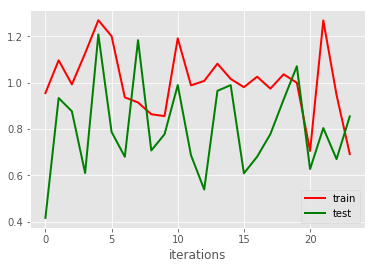

In [14]:
plt.figure()
plt.plot(train_hist,color='r',linewidth=2,label='train')
plt.plot(val_hist,color='g',linewidth=2,label='test')
plt.xlabel('iterations')
plt.legend()
plt.show()

### Neural Network Predictions

#### We can now evaluate the predicted segmentations our network makes by computing predictions on the test set and visualizing them. Our network does a reasonable job at identifying the general locations of the tumors and their severity which is not bad considering that we used a simple convolutional network. However, in some cases the network over segments or misses key parts of the tumor.

#### To get better performance we could experiment with different neural networks, e.g. trying more layers, more parameters, different activation functions, experimenting with pooling layers etc.

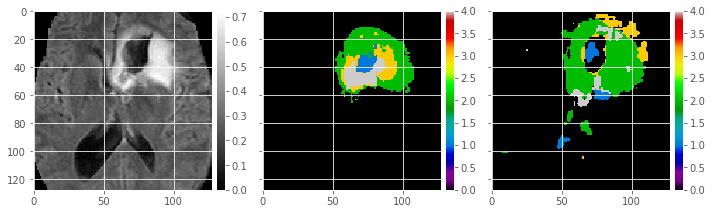

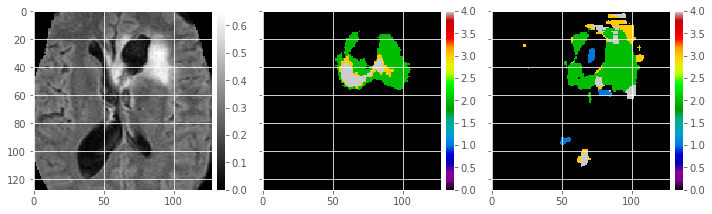

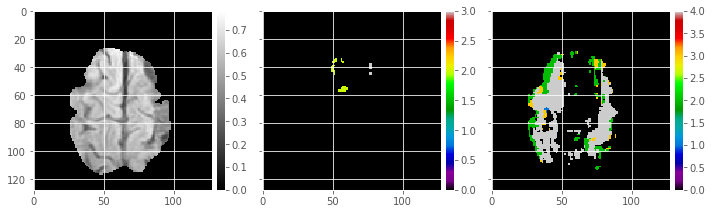

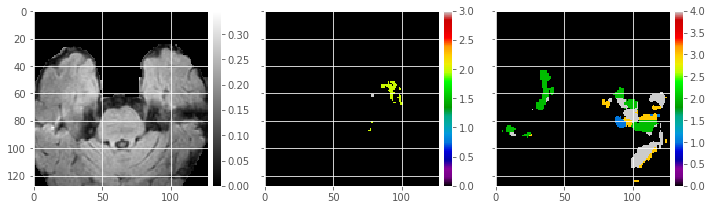

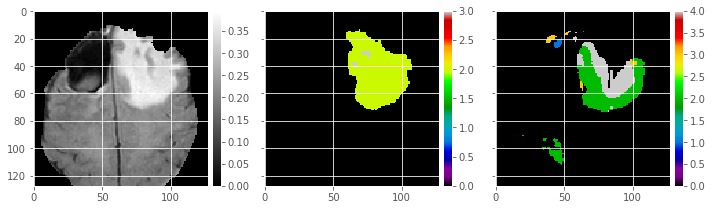

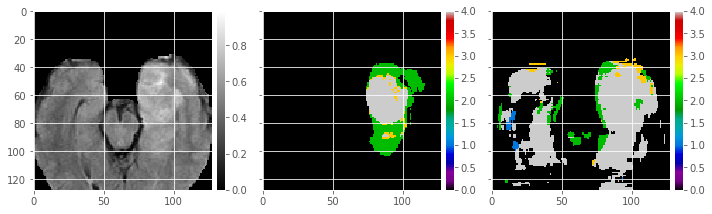

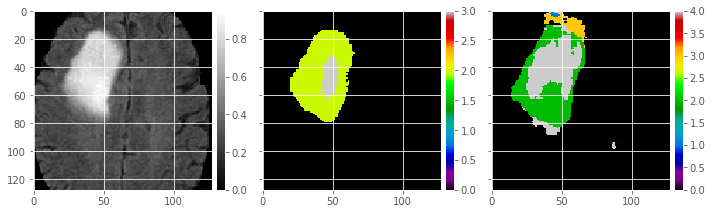

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def implot(mp,ax,cmap='gray'):
    im = ax.imshow(mp.astype(np.float32), cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    
xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)

yh = sess.run(yhat,{x:xb})

ypred = np.argmax(yh,axis=3)

for i in range(7):

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(10,3))
    implot(xb[i,:,:,0],ax1)
    implot(yb[i,:,:],ax2,cmap='spectral')
    implot(ypred[i,:,:],ax3,cmap='spectral')
    plt.grid('off')
    plt.tight_layout()
    plt.savefig('images_{}.pdf'.format(i),dpi=600)
    plt.show()